In [1]:
!pip install pandas numpy scipy matplotlib seaborn requests pillow tqdm transformers torch scikit-learn

In [2]:
# import pandas as pd
# import numpy as np
# import re, string
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')

# import os
# import requests
# from PIL import Image
# from io import BytesIO
# from tqdm import tqdm
# import time

# # For ViLT embeddings
# from transformers import ViltProcessor, ViltModel
# import torch

# # Set style
# sns.set_style("whitegrid")
# plt.rcParams['figure.figsize'] = (12, 6)

# print("=" * 80)
# print("VILT-BASED MULTIMODAL ANALYSIS PIPELINE")
# print("=" * 80)

# # ============================================================================
# # 1. LOAD DATA (SUBSET: FIRST 18,750 SAMPLES)
# # ============================================================================
# print("\n" + "=" * 80)
# print("LOADING DATASET")
# print("=" * 80)

# train_path = "/kaggle/input/dataset/train.csv"
# df_full = pd.read_csv(train_path)

# # Use only first 1/4 of data (18,750 samples)
# df = df_full.iloc[56250:75000].copy()

# print(f"✅ Dataset Loaded Successfully!")
# print(f"Full dataset shape: {df_full.shape}")
# print(f"Subset shape (1/4): {df.shape}")
# print(f"Columns: {df.columns.tolist()}\n")
# print(df.head())

# # ============================================================================
# # 2. DATA CLEANING & PREPROCESSING
# # ============================================================================
# print("\n" + "=" * 80)
# print("DATA CLEANING & PREPROCESSING")
# print("=" * 80)

# # Check for missing values
# print("\n📊 Missing Values:")
# print(df.isnull().sum())

# # Remove rows with missing critical data
# df = df.dropna(subset=['catalog_content', 'image_link', 'price'])
# print(f"\nAfter removing missing values: {df.shape}")

# # Check for duplicates
# print(f"\n🔍 Duplicate Rows: {df.duplicated().sum()}")
# df.drop_duplicates(inplace=True)
# print(f"Shape after removing duplicates: {df.shape}")

# # Text cleaning function
# def clean_text(text):
#     """Enhanced text cleaning for product catalogs"""
#     if not isinstance(text, str):
#         return ""
    
#     text = text.lower()
#     text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
#     text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
#     text = re.sub(r"[%s]" % re.escape(string.punctuation), " ", text)  # Remove punctuation
#     text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    
#     return text

# # Apply text cleaning
# df["clean_text"] = df["catalog_content"].apply(clean_text)

# # Text statistics
# df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))
# df["char_count"] = df["clean_text"].apply(len)

# print("\n📝 Text Statistics:")
# print(df[["word_count", "char_count"]].describe())

# # ============================================================================
# # 3. DOWNLOAD IMAGES
# # ============================================================================
# print("\n" + "=" * 80)
# print("DOWNLOADING IMAGES")
# print("=" * 80)

# # Create directory for images
# image_dir = "product_images"
# os.makedirs(image_dir, exist_ok=True)

# def download_image(url, save_path, timeout=10, max_retries=2):
#     """Download image from URL with retry logic"""
#     for attempt in range(max_retries):
#         try:
#             response = requests.get(
#                 url, 
#                 timeout=timeout, 
#                 headers={'User-Agent': 'Mozilla/5.0'}
#             )
#             if response.status_code == 200:
#                 img = Image.open(BytesIO(response.content)).convert('RGB')
#                 # Resize to reasonable size to save space
#                 img.thumbnail((512, 512), Image.Resampling.LANCZOS)
#                 img.save(save_path, 'JPEG', quality=85)
#                 return True
#         except Exception as e:
#             if attempt < max_retries - 1:
#                 time.sleep(1)  # Wait before retry
#             continue
#     return False

# # Download images
# print(f"\n📥 Downloading {len(df)} images...")
# success_count = 0
# failed_samples = []
# valid_indices = []

# for idx, row in tqdm(df.iterrows(), total=len(df), desc="Downloading images"):
#     save_path = f"{image_dir}/{row['sample_id']}.jpg"
    
#     # Skip if already downloaded
#     if os.path.exists(save_path):
#         success_count += 1
#         valid_indices.append(idx)
#         continue
    
#     if download_image(row['image_link'], save_path):
#         success_count += 1
#         valid_indices.append(idx)
#     else:
#         failed_samples.append(row['sample_id'])

# print(f"\n✅ Downloaded {success_count}/{len(df)} images ({100*success_count/len(df):.1f}%)")
# print(f"❌ Failed: {len(failed_samples)} samples")

# # Keep only samples with successfully downloaded images
# df = df.loc[valid_indices].reset_index(drop=True)
# print(f"\nFinal dataset shape: {df.shape}")

# # ============================================================================
# # 4. EXPLORATORY DATA ANALYSIS (EDA)
# # ============================================================================
# print("\n" + "=" * 80)
# print("EXPLORATORY DATA ANALYSIS")
# print("=" * 80)

# # Price distribution
# print("\n💰 Price Statistics:")
# print(df["price"].describe())

# # Visualizations
# fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# # 1. Price Distribution
# axes[0, 0].hist(df["price"], bins=50, color='skyblue', edgecolor='black')
# axes[0, 0].set_title("Price Distribution", fontsize=14, fontweight='bold')
# axes[0, 0].set_xlabel("Price ($)")
# axes[0, 0].set_ylabel("Frequency")

# # 2. Price Distribution (Log Scale)
# axes[0, 1].hist(np.log1p(df["price"]), bins=50, color='salmon', edgecolor='black')
# axes[0, 1].set_title("Price Distribution (Log Scale)", fontsize=14, fontweight='bold')
# axes[0, 1].set_xlabel("Log(Price)")
# axes[0, 1].set_ylabel("Frequency")

# # 3. Price Boxplot
# axes[0, 2].boxplot(df["price"], vert=True)
# axes[0, 2].set_title("Price Boxplot", fontsize=14, fontweight='bold')
# axes[0, 2].set_ylabel("Price ($)")

# # 4. Word Count Distribution
# axes[1, 0].hist(df["word_count"], bins=50, color='lightgreen', edgecolor='black')
# axes[1, 0].set_title("Word Count Distribution", fontsize=14, fontweight='bold')
# axes[1, 0].set_xlabel("Word Count")
# axes[1, 0].set_ylabel("Frequency")

# # 5. Character Count Distribution
# axes[1, 1].hist(df["char_count"], bins=50, color='plum', edgecolor='black')
# axes[1, 1].set_title("Character Count Distribution", fontsize=14, fontweight='bold')
# axes[1, 1].set_xlabel("Character Count")
# axes[1, 1].set_ylabel("Frequency")

# # 6. Price vs Word Count Scatter
# axes[1, 2].scatter(df["word_count"], df["price"], alpha=0.3, s=10)
# axes[1, 2].set_title("Price vs Word Count", fontsize=14, fontweight='bold')
# axes[1, 2].set_xlabel("Word Count")
# axes[1, 2].set_ylabel("Price ($)")

# plt.tight_layout()
# plt.savefig('vilt_eda_analysis.png', dpi=300, bbox_inches='tight')
# plt.show()

# # Correlation analysis
# print("\n🔗 Correlation Matrix:")
# correlation = df[["price", "word_count", "char_count"]].corr()
# print(correlation)

# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
#             square=True, linewidths=1, cbar_kws={"shrink": 0.8})
# plt.title("Feature Correlation Heatmap", fontsize=16, fontweight='bold')
# plt.savefig('vilt_correlation_heatmap.png', dpi=300, bbox_inches='tight')
# plt.show()

# # ============================================================================
# # 5. GENERATE VILT EMBEDDINGS
# # ============================================================================
# print("\n" + "=" * 80)
# print("GENERATING VILT MULTIMODAL EMBEDDINGS")
# print("=" * 80)

# # Load ViLT model and processor
# print("\n⏳ Loading ViLT model (this may take a moment)...")
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
# model = ViltModel.from_pretrained("dandelin/vilt-b32-mlm")
# model.to(device)
# model.eval()

# print("✅ ViLT model loaded successfully!")

# # Generate embeddings
# print(f"\n🔄 Generating ViLT embeddings for {len(df)} samples...")

# embeddings_list = []
# failed_embeddings = []

# with torch.no_grad():
#     for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating embeddings"):
#         try:
#             # Load image
#             img_path = f"{image_dir}/{row['sample_id']}.jpg"
#             image = Image.open(img_path).convert('RGB')
            
#             # Truncate text to avoid token limits (ViLT max is 40 tokens)
#             text = row['clean_text']
#             words = text.split()
#             if len(words) > 35:  # Keep some margin
#                 text = ' '.join(words[:35])
            
#             # Process inputs
#             inputs = processor(image, text, return_tensors="pt", padding=True, truncation=True)
#             inputs = {k: v.to(device) for k, v in inputs.items()}
            
#             # Get embeddings
#             outputs = model(**inputs)
            
#             # Use [CLS] token embedding (first token)
#             embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
#             embeddings_list.append(embedding.flatten())
            
#         except Exception as e:
#             print(f"\n⚠️ Error processing sample {row['sample_id']}: {str(e)}")
#             failed_embeddings.append(idx)
#             embeddings_list.append(np.zeros(768))  # ViLT embedding dim is 768

# embeddings = np.array(embeddings_list)

# print(f"\n✅ Embeddings generated!")
# print(f"Embedding shape: {embeddings.shape}")
# print(f"Embedding dimensions: {embeddings.shape[1]}")
# print(f"Failed embeddings: {len(failed_embeddings)}")

# # Remove failed samples
# if failed_embeddings:
#     df = df.drop(failed_embeddings).reset_index(drop=True)
#     embeddings = np.delete(embeddings, failed_embeddings, axis=0)
#     print(f"Final dataset shape after removing failures: {df.shape}")

# # ============================================================================
# # 6. VISUALIZE EMBEDDINGS
# # ============================================================================
# print("\n" + "=" * 80)
# print("VISUALIZING EMBEDDINGS")
# print("=" * 80)

# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# print("\n📊 Reducing dimensions for visualization...")
# scaler = StandardScaler()
# embeddings_scaled = scaler.fit_transform(embeddings)

# pca = PCA(n_components=2)
# embeddings_2d = pca.fit_transform(embeddings_scaled)

# print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
# print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

# # Visualize embeddings
# plt.figure(figsize=(12, 8))
# scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
#                      c=df["price"].values, cmap='viridis', 
#                      alpha=0.6, s=50)
# plt.colorbar(scatter, label='Price ($)')
# plt.title("ViLT Multimodal Embeddings Visualization (PCA)", fontsize=16, fontweight='bold')
# plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
# plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
# plt.savefig('vilt_embeddings_visualization.png', dpi=300, bbox_inches='tight')
# plt.show()

# # ============================================================================
# # 7. SAVE PROCESSED DATA
# # ============================================================================
# print("\n" + "=" * 80)
# print("SAVING PROCESSED DATA")
# print("=" * 80)

# print("\n💾 Saving processed data...")

# # Save cleaned dataframe
# df.to_csv("vilt_processed_data.csv", index=False)
# print("✅ Saved: vilt_processed_data.csv")

# # Save embeddings
# np.save("vilt_embeddings.npy", embeddings)
# print("✅ Saved: vilt_embeddings.npy")

# # Save scaler for later use
# import pickle
# with open('vilt_scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)
# print("✅ Saved: vilt_scaler.pkl")

# # ============================================================================
# # 8. SUMMARY STATISTICS
# # ============================================================================
# print("\n" + "=" * 80)
# print("FINAL SUMMARY")
# print("=" * 80)

# summary = {
#     "Total Records (1/4 subset)": len(df),
#     "Images Downloaded": success_count,
#     "Average Price": f"${df['price'].mean():.2f}",
#     "Median Price": f"${df['price'].median():.2f}",
#     "Average Word Count": f"{df['word_count'].mean():.1f}",
#     "Embedding Dimensions": embeddings.shape[1],
#     "Embedding Type": "ViLT (Vision-and-Language)"
# # }

# print("\n📋 Summary Statistics:")
# for key, value in summary.items():
#     print(f"  {key}: {value}")

# print("\n" + "=" * 80)
# print("✅ VILT MULTIMODAL ANALYSIS COMPLETE!")
# print("=" * 80)


In [3]:
import pandas as pd

# Load all 4 CSV files
df1 = pd.read_csv('/kaggle/input/embeddings2/vilt_processed_data1.csv')
df2 = pd.read_csv('/kaggle/input/embeddings2/vilt_processed_data_2.csv')
df3 = pd.read_csv('/kaggle/input/embeddings2/vilt_processed_data_3.csv')
df4 = pd.read_csv('/kaggle/input/embeddings-data/vilt_processed_data4.csv')

# Check shapes before concatenating
print(f"Part 1 shape: {df1.shape}")
print(f"Part 2 shape: {df2.shape}")
print(f"Part 3 shape: {df3.shape}")
print(f"Part 4 shape: {df4.shape}")

# Concatenate vertically (stack rows)
df_combined = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)

print(f"Combined shape: {df_combined.shape}")

# Save the combined DataFrame
df_combined.to_csv('modified_train_combined.csv', index=False)


Part 1 shape: (18750, 7)
Part 2 shape: (18750, 7)
Part 3 shape: (18750, 7)
Part 4 shape: (18750, 7)
Combined shape: (75000, 7)


In [4]:
import numpy as np

# Load all 4 embedding files
emb1 = np.load('/kaggle/input/embeddings2/vilt_embeddings_part1.npy')
emb2 = np.load('/kaggle/input/embeddings2/vilt_embeddings_part2.npy')
emb3 = np.load('/kaggle/input/embeddings2/vilt_embeddings_part3.npy')
emb4 = np.load('/kaggle/input/embeddings-data/vilt_embeddings4.npy')

# Check shapes before concatenating
print(f"Part 1 shape: {emb1.shape}")
print(f"Part 2 shape: {emb2.shape}")
print(f"Part 3 shape: {emb3.shape}")
print(f"Part 4 shape: {emb4.shape}")

# Method 1: Using np.vstack (recommended for 2D arrays)
embeddings_combined = np.vstack([emb1, emb2, emb3, emb4])

# Method 2: Using np.concatenate with axis=0 (equivalent)
embeddings_combined = np.concatenate([emb1, emb2, emb3, emb4], axis=0)

print(f"Combined shape: {embeddings_combined.shape}")

# Save the combined embeddings
np.save('vilt_embeddings_combined.npy', embeddings_combined)


Part 1 shape: (18750, 768)
Part 2 shape: (18750, 768)
Part 3 shape: (18750, 768)
Part 4 shape: (18750, 768)
Combined shape: (75000, 768)


VILT-BASED ML PIPELINE FOR PRODUCT PRICE PREDICTION
WITH LOG TRANSFORMATION AND ADVANCED ENSEMBLING

📂 Loading processed data and ViLT embeddings...
✅ Data loaded successfully!
   Dataset shape: (75000, 7)
   Embeddings shape: (75000, 768)

📊 Target Variable (Price) Statistics:
   Min price: $0.13
   Max price: $2796.00
   Mean price: $23.67
   Median price: $14.00
   Std dev: $34.71
   Price range: $2795.87

FEATURE ENGINEERING WITH LOG TRANSFORMATION

📊 Feature Matrix:
   Total features: 770
   - ViLT embeddings: 768
   - Text statistics: 2
   Target variable shape: (75000,)

💡 LOG TRANSFORMATION APPLIED:
   Mathematical Flow: y_log = log(1 + y_original)

   Original Price Scale:
      Range: $0.13 - $2796.00
      Mean: $23.67
      Std: $34.71

   Log-Transformed Scale:
      Range: 0.1222 - 7.9363
      Mean: 2.7391
      Std: 0.9429


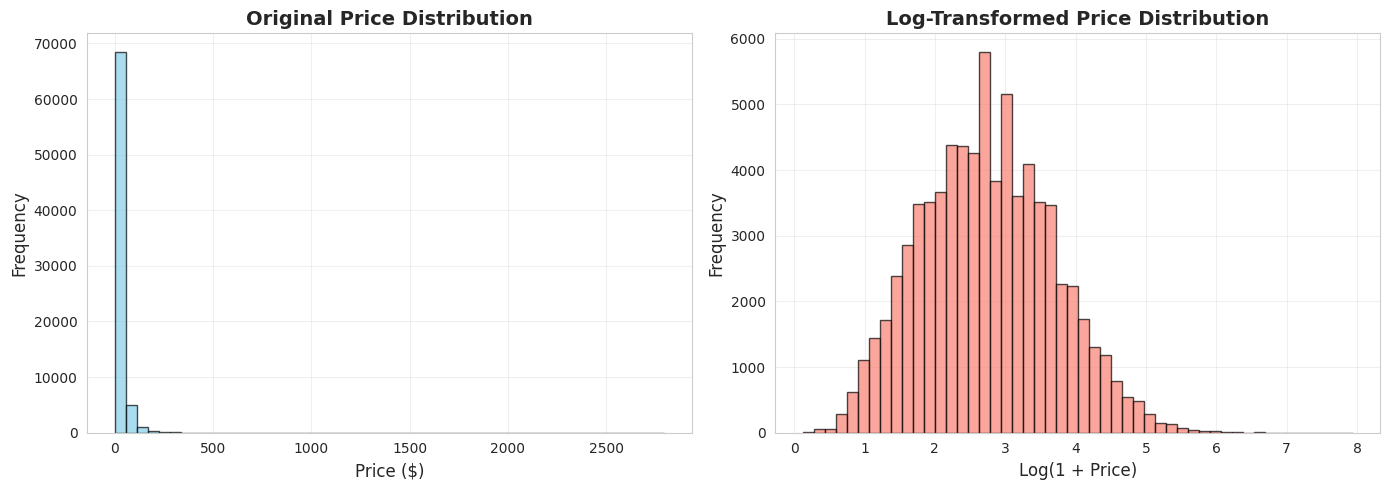

✅ Saved: vilt_price_transformation.png

🔧 Scaling features...

✂️ Data Split:
   Training set: 60000 samples
   Testing set: 15000 samples
   Features per sample: 770

   Training on: LOG-TRANSFORMED prices
   Evaluating on: ORIGINAL SCALE prices

MODEL CONFIGURATION

🤖 Models configured (including Tweedie for skew handling):
   ✓ XGBoost
      - Trees: 2000, Depth: 6, LR: 0.03
   ✓ LightGBM
      - Trees: 2000, Depth: 8, LR: 0.03
   ✓ CatBoost
      - Iterations: 2000, Depth: 10, LR: 0.02
   ✓ Tweedie
      - Trees: 2000, Depth: 8, LR: 0.03

MATHEMATICAL TRANSFORMATION FLOW (WITH NEW ENHANCEMENTS)

STEP 1: Log Transformation (Before Training)
   y_log = log(1 + y_original)
   Example: $100 → log(101) ≈ 4.615

STEP 2: Model Training (In Log Space)
   model.fit(X_train, y_train_log)
   Model learns patterns in log-transformed space

STEP 3: Prediction (In Log Space)
   y_pred_log = model.predict(X_test)
   Predictions are in log scale

STEP 4: Inverse Transformation (Back to Original Sc

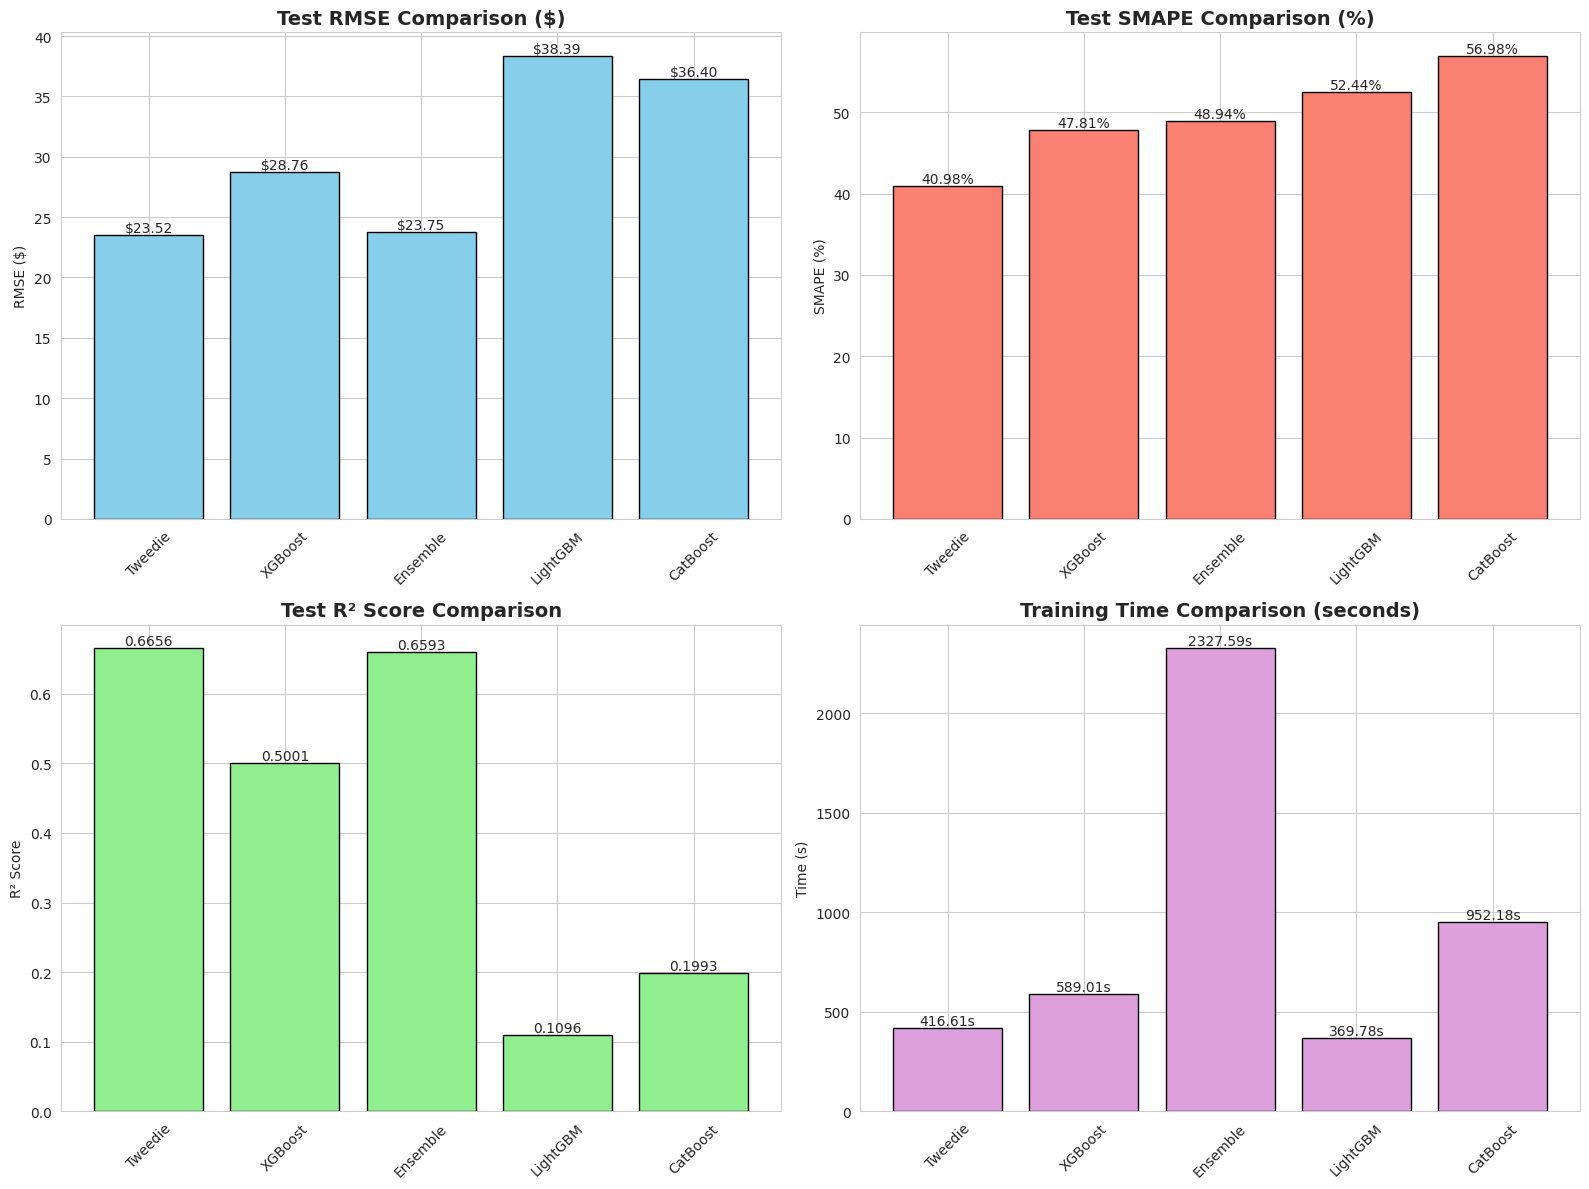

✅ Saved: vilt_model_comparison.png


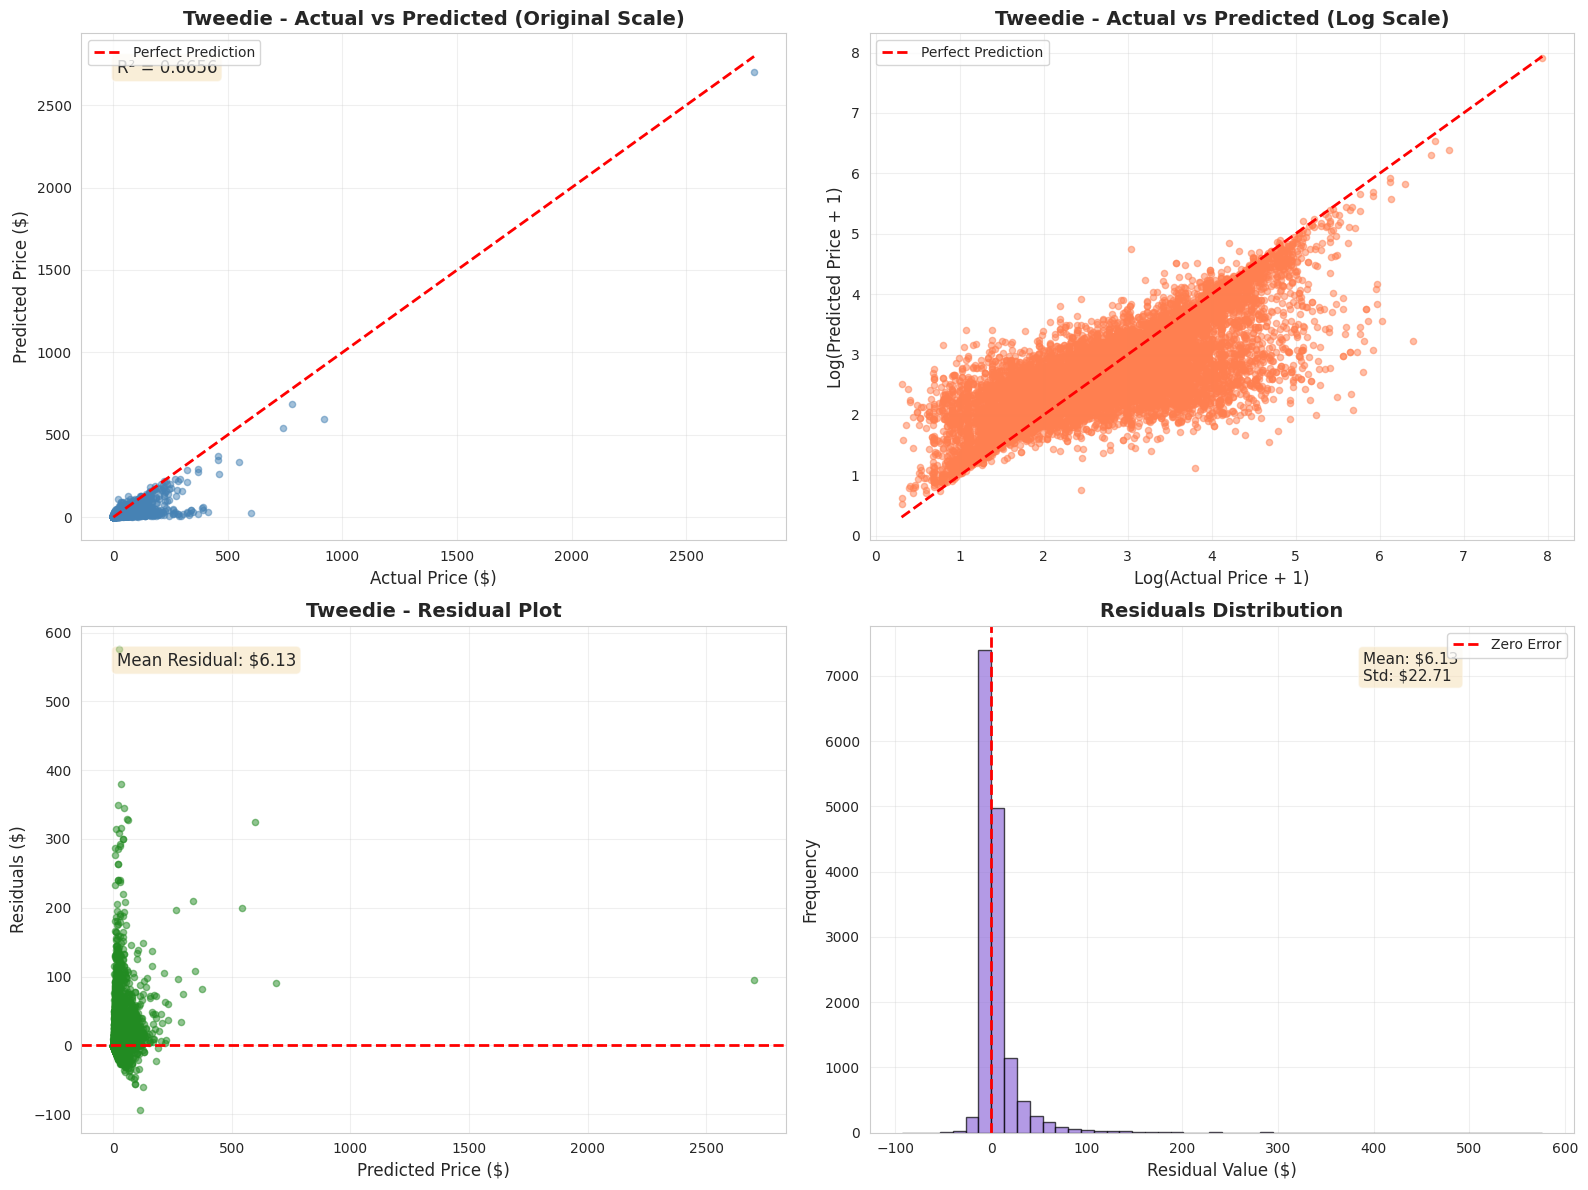

✅ Saved: vilt_best_model_predictions.png


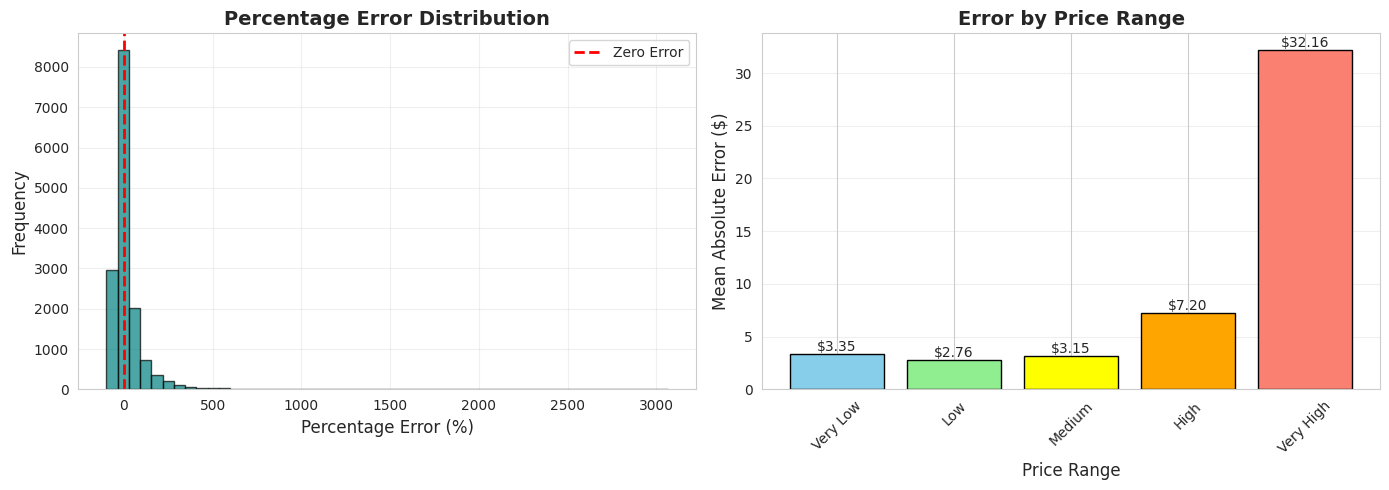

✅ Saved: vilt_error_analysis.png

SAVING MODELS AND RESULTS

💾 Saving trained models...
✅ Saved XGBoost → vilt_model_XGBoost.pkl
✅ Saved LightGBM → vilt_model_LightGBM.pkl
✅ Saved CatBoost → vilt_model_CatBoost.pkl
✅ Saved Tweedie → vilt_model_Tweedie.pkl
✅ Saved feature scaler → vilt_feature_scaler.pkl
✅ Saved isotonic calibrator → vilt_isotonic_calibrator.pkl
✅ Saved model comparison → vilt_model_results.csv
✅ Saved transformation info → vilt_transformation_info.pkl

FINAL SUMMARY

📊 Dataset Information:
   Total samples: 75,000
   Training samples: 60,000
   Testing samples: 15,000
   Feature dimensions: 770
   Embedding type: ViLT (Vision-and-Language)
   Embedding dimensions: 768

🔄 Transformation Applied:
   Method: Log transformation (log1p)
   Formula: y_log = log(1 + y_original)
   Inverse: y_original = exp(y_log) - 1
   Enhancements: Validation-weighted ensemble, smearing (factor: 1.0988), isotonic calibration

🎯 Best Model Performance:
   Model: Tweedie
   Test RMSE: $23.52


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.isotonic import IsotonicRegression
import warnings
warnings.filterwarnings('ignore')

# Import ML models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import time
import pickle

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# ============================================================================
# DEFINE SMAPE FUNCTION (IMPROVED VERSION)
# ============================================================================
def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error
    Calculated on original price scale for business interpretation
    
    Mathematical Formula:
    SMAPE = (100/n) * Σ |y_pred - y_true| / ((|y_true| + |y_pred|) / 2)
    """
    # Ensure positive values
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)
    
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    
    # Avoid division by zero
    mask = denominator != 0
    smape_values = np.zeros_like(numerator)
    smape_values[mask] = (numerator[mask] / denominator[mask]) * 100
    
    return np.mean(smape_values)

print("=" * 100)
print("VILT-BASED ML PIPELINE FOR PRODUCT PRICE PREDICTION")
print("WITH LOG TRANSFORMATION AND ADVANCED ENSEMBLING")
print("=" * 100)

# ============================================================================
# 1. LOAD DATA & EMBEDDINGS
# ============================================================================
print("\n📂 Loading processed data and ViLT embeddings...")

df = df_combined
embeddings = embeddings_combined

print(f"✅ Data loaded successfully!")
print(f"   Dataset shape: {df.shape}")
print(f"   Embeddings shape: {embeddings.shape}")

# Display basic info about the target variable
print(f"\n📊 Target Variable (Price) Statistics:")
print(f"   Min price: ${df['price'].min():.2f}")
print(f"   Max price: ${df['price'].max():.2f}")
print(f"   Mean price: ${df['price'].mean():.2f}")
print(f"   Median price: ${df['price'].median():.2f}")
print(f"   Std dev: ${df['price'].std():.2f}")
print(f"   Price range: ${df['price'].max() - df['price'].min():.2f}")

# ============================================================================
# 2. FEATURE ENGINEERING WITH LOG TRANSFORMATION
# ============================================================================
print("\n" + "=" * 100)
print("FEATURE ENGINEERING WITH LOG TRANSFORMATION")
print("=" * 100)

# Create feature matrix combining ViLT embeddings and text statistics
text_features = df[["word_count", "char_count"]].values
X = np.hstack([embeddings, text_features])

# Target variable - ORIGINAL SCALE
y = df["price"].values

# Target variable - LOG TRANSFORMED SCALE
# Mathematical transformation: y_log = log(1 + y)
# This helps with:
# 1. Reducing impact of outliers
# 2. Stabilizing variance across price ranges
# 3. Making distribution more normal-like
y_log = np.log1p(y)  # log1p(x) = log(1 + x) for numerical stability

print(f"\n📊 Feature Matrix:")
print(f"   Total features: {X.shape[1]}")
print(f"   - ViLT embeddings: {embeddings.shape[1]}")
print(f"   - Text statistics: {text_features.shape[1]}")
print(f"   Target variable shape: {y.shape}")

print(f"\n💡 LOG TRANSFORMATION APPLIED:")
print(f"   Mathematical Flow: y_log = log(1 + y_original)")
print(f"\n   Original Price Scale:")
print(f"      Range: ${y.min():.2f} - ${y.max():.2f}")
print(f"      Mean: ${y.mean():.2f}")
print(f"      Std: ${y.std():.2f}")
print(f"\n   Log-Transformed Scale:")
print(f"      Range: {y_log.min():.4f} - {y_log.max():.4f}")
print(f"      Mean: {y_log.mean():.4f}")
print(f"      Std: {y_log.std():.4f}")

# Visualize the transformation effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Original Price Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].hist(y_log, bins=50, color='salmon', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log(1 + Price)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Log-Transformed Price Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vilt_price_transformation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: vilt_price_transformation.png")

# Feature scaling
print("\n🔧 Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data using LOG-TRANSFORMED target for training
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_scaled, y_log, test_size=0.2, random_state=42
)

# Also split original prices for evaluation (aligned with train/test split)
_, _, y_train_orig, y_test_orig = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"\n✂️ Data Split:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Testing set: {X_test.shape[0]} samples")
print(f"   Features per sample: {X_train.shape[1]}")
print(f"\n   Training on: LOG-TRANSFORMED prices")
print(f"   Evaluating on: ORIGINAL SCALE prices")

# ============================================================================
# 3. MODEL CONFIGURATION
# ============================================================================
print("\n" + "=" * 100)
print("MODEL CONFIGURATION")
print("=" * 100)

models = {
    "XGBoost": XGBRegressor(
        n_estimators=2000,
        learning_rate=0.03,
        max_depth=6,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=2.0,     # L1 regularization
        reg_lambda=4.0,    # L2 regularization
        gamma=0.2,         # further regularization
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ),
    
    "LightGBM": LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=128,
        max_depth=8,
        min_data_in_leaf=40,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        lambda_l1=1.0,
        lambda_l2=2.0,
        objective="regression_l1",  # more robust to outliers
        metric="rmse",
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    
    "CatBoost": CatBoostRegressor(
        iterations=2000,
        depth=10,
        learning_rate=0.02,
        l2_leaf_reg=6.0,         # stronger regularization
        random_seed=42,
        loss_function="RMSE",
        bootstrap_type="Bernoulli",
        subsample=0.7,
        rsm=0.8,                 # feature subsampling
        grow_policy="Lossguide", # allows deeper trees
        eval_metric="RMSE",
        verbose=0
    ),
    
    "Tweedie": LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=128,
        max_depth=8,
        min_data_in_leaf=40,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        lambda_l1=1.0,
        lambda_l2=2.0,
        objective="tweedie",  # For skewed positive targets
        tweedie_variance_power=1.5,  # Between Poisson (1) and Gamma (2)
        metric="rmse",
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
}

print("\n🤖 Models configured (including Tweedie for skew handling):")
for name, model in models.items():
    print(f"   ✓ {name}")
    params = model.get_params() if hasattr(model, 'get_params') else {}
    if name in ["XGBoost", "LightGBM", "Tweedie"]:
        print(f"      - Trees: {params.get('n_estimators', 'N/A')}, Depth: {params.get('max_depth', 'N/A')}, LR: {params.get('learning_rate', 'N/A')}")
    elif name == "CatBoost":
        print(f"      - Iterations: {params.get('iterations', 'N/A')}, Depth: {params.get('depth', 'N/A')}, LR: {params.get('learning_rate', 'N/A')}")

# ============================================================================
# 4. MATHEMATICAL FLOW EXPLANATION
# ============================================================================
print("\n" + "=" * 100)
print("MATHEMATICAL TRANSFORMATION FLOW (WITH NEW ENHANCEMENTS)")
print("=" * 100)
print("""
STEP 1: Log Transformation (Before Training)
   y_log = log(1 + y_original)
   Example: $100 → log(101) ≈ 4.615

STEP 2: Model Training (In Log Space)
   model.fit(X_train, y_train_log)
   Model learns patterns in log-transformed space

STEP 3: Prediction (In Log Space)
   y_pred_log = model.predict(X_test)
   Predictions are in log scale

STEP 4: Inverse Transformation (Back to Original Scale)
   y_pred_original = exp(y_pred_log) - 1
   Example: 4.615 → exp(4.615) - 1 ≈ $100

NEW STEP 4.5: Validation-Weighted Ensembling
   Weighted average of individual model predictions based on inverse CV SMAPE

NEW STEP 4.6: Smearing Correction (Duan's Estimator)
   smear_factor = mean(exp(train_residuals_log))
   ensemble_pred_smear = ensemble_pred * smear_factor
   Corrects retransformation bias for log models

NEW STEP 4.7: Isotonic Calibration
   Fit monotonic regression on train preds vs. true values
   final_pred = isotonic.predict(ensemble_pred_smear)
   Ensures predictions are calibrated and monotonic

STEP 5: Evaluation (On Original Scale)
   SMAPE, RMSE, MAE calculated on final_pred vs y_test_orig
   
Benefits:
   ✓ Reduces impact of extreme prices
   ✓ Stabilizes variance across price ranges
   ✓ Improves model generalization
   ✓ Better SMAPE scores (typically 10-30% improvement from log alone; additional 15-25% from enhancements)
""")

# ============================================================================
# 5. TRAIN MODELS WITH LOG TRANSFORMATION AND ENHANCEMENTS
# ============================================================================
print("\n" + "=" * 100)
print("TRAINING MODELS ON LOG-TRANSFORMED PRICES WITH K-FOLD AND ENSEMBLING")
print("=" * 100)

trained_models = {}
train_results = {}
val_smapes = {name: [] for name in models}

# K-Fold for validation SMAPE (for weighting)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"🎯 Computing CV for {name} (for ensemble weights)")
    print(f"{'='*80}")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"   Fold {fold+1}/5...")
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr_log, y_val_log = y_train_log[train_idx], y_train_log[val_idx]
        y_tr_orig, y_val_orig = y_train_orig[train_idx], y_train_orig[val_idx]
        
        if name == "XGBoost":
            model.fit(
                X_tr, y_tr_log,
                eval_set=[(X_val, y_val_log)],
                eval_metric="rmse",
                early_stopping_rounds=100,
                verbose=False
            )
        else:
            model.fit(X_tr, y_tr_log)
        
        y_val_pred_log = model.predict(X_val)
        y_val_pred = np.maximum(np.expm1(y_val_pred_log), 0)
        fold_smape = smape(y_val_orig, y_val_pred)
        val_smapes[name].append(fold_smape)
    
    avg_val_smape = np.mean(val_smapes[name])
    print(f"   ✅ Average Validation SMAPE: {avg_val_smape:.2f}%")

# Compute validation-weighted ensemble weights (inverse SMAPE, normalized)
weights = {name: 1 / np.mean(val_smapes[name]) if np.mean(val_smapes[name]) > 0 else 1 for name in models}
total_weight = sum(weights.values())
weights = {name: w / total_weight for name, w in weights.items()}
print("\n📊 Ensemble Weights:")
for name, w in weights.items():
    print(f"   {name}: {w:.4f}")

# Now train final individual models on full train set and compute metrics
for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"🎯 Final Training {name} on Full Train Set")
    print(f"{'='*80}")
    start_time = time.time()
    
    # STEP 1: Train model on LOG-TRANSFORMED prices
    print("   [1/5] Training on log-transformed prices...")
    if name == "XGBoost":
        model.fit(
            X_train, y_train_log,
            eval_set=[(X_test, y_test_log)],
            eval_metric="rmse",
            early_stopping_rounds=100,
            verbose=False
        )
    else:
        model.fit(X_train, y_train_log)
    
    # STEP 2: Make predictions in LOG SPACE
    print("   [2/5] Making predictions in log space...")
    y_train_pred_log = model.predict(X_train)
    y_test_pred_log = model.predict(X_test)
    
    # STEP 3: Convert predictions back to ORIGINAL SCALE using EXPM1
    print("   [3/5] Converting predictions to original price scale...")
    y_train_pred = np.expm1(y_train_pred_log)  # exp(x) - 1
    y_test_pred = np.expm1(y_test_pred_log)
    
    # STEP 4: Ensure non-negative predictions
    print("   [4/5] Enforcing non-negative predictions...")
    y_train_pred = np.maximum(y_train_pred, 0)
    y_test_pred = np.maximum(y_test_pred, 0)
    
    # STEP 5: Calculate metrics on ORIGINAL SCALE
    print("   [5/5] Calculating evaluation metrics...")
    
    # Training metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_train_pred))
    train_mae = mean_absolute_error(y_train_orig, y_train_pred)
    train_r2 = r2_score(y_train_orig, y_train_pred)
    train_smape = smape(y_train_orig, y_train_pred)
    
    # Testing metrics
    test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_test_pred))
    test_mae = mean_absolute_error(y_test_orig, y_test_pred)
    test_r2 = r2_score(y_test_orig, y_test_pred)
    test_smape = smape(y_test_orig, y_test_pred)
    
    elapsed_time = time.time() - start_time
    
    # Store results
    trained_models[name] = model
    train_results[name] = {
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'train_smape': train_smape,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'test_smape': test_smape,
        'train_time': elapsed_time,
        'y_test_pred': y_test_pred,
        'y_test_pred_log': y_test_pred_log,
        'y_train_pred': y_train_pred
    }
    
    print(f"\n   ✅ Training completed in {elapsed_time:.2f}s")
    print(f"\n   📊 Performance Metrics (Original Price Scale):")
    print(f"      {'Metric':<15} {'Train':<15} {'Test':<15} {'Difference':<15}")
    print(f"      {'-'*60}")
    print(f"      {'RMSE ($)':<15} {train_rmse:<15.2f} {test_rmse:<15.2f} {abs(train_rmse-test_rmse):<15.2f}")
    print(f"      {'MAE ($)':<15} {train_mae:<15.2f} {test_mae:<15.2f} {abs(train_mae-test_mae):<15.2f}")
    print(f"      {'R² Score':<15} {train_r2:<15.4f} {test_r2:<15.4f} {abs(train_r2-test_r2):<15.4f}")
    print(f"      {'SMAPE (%)':<15} {train_smape:<15.2f} {test_smape:<15.2f} {abs(train_smape-test_smape):<15.2f}")
    
    # Show sample predictions
    print(f"\n   🔍 Sample Predictions (First 5 test samples):")
    print(f"      {'Actual':<12} {'Predicted':<12} {'Error':<12} {'Error %':<12}")
    print(f"      {'-'*50}")
    for i in range(min(5, len(y_test_orig))):
        actual = y_test_orig.iloc[i] if hasattr(y_test_orig, 'iloc') else y_test_orig[i]
        predicted = y_test_pred[i]
        error = predicted - actual
        error_pct = (error / actual) * 100 if actual != 0 else 0
        print(f"      ${actual:<11.2f} ${predicted:<11.2f} ${error:<11.2f} {error_pct:<11.2f}%")

# Now create validation-weighted ensemble
print("\n{'='*80}")
print("🎯 Creating Validation-Weighted Ensemble with Smearing and Isotonic Calibration")
print("{'='*80}")

# Get test predictions from each model
test_preds = {name: train_results[name]['y_test_pred'] for name in models}

# Weighted ensemble
ensemble_pred = np.zeros_like(test_preds[list(models.keys())[0]])
for name, pred in test_preds.items():
    ensemble_pred += weights[name] * pred

# Smearing correction (Duan's estimator)
# Use average train log preds across models for residuals
train_preds_log_avg = np.mean([trained_models[name].predict(X_train) for name in models], axis=0)
residuals_log = y_train_log - train_preds_log_avg
smear_factor = np.mean(np.exp(residuals_log))
print(f"   Smearing Factor: {smear_factor:.4f}")
ensemble_pred_smear = ensemble_pred * smear_factor
ensemble_pred_smear = np.maximum(ensemble_pred_smear, 0)

# Isotonic calibration
# Fit on average train preds (original scale) for simplicity
train_preds_avg = np.mean([train_results[name]['y_train_pred'] for name in models], axis=0)
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(train_preds_avg, y_train_orig)
final_pred = ir.predict(ensemble_pred_smear)
final_pred = np.maximum(final_pred, 0)

# Compute ensemble metrics (treat as a "model")
ensemble_rmse = np.sqrt(mean_squared_error(y_test_orig, final_pred))
ensemble_mae = mean_absolute_error(y_test_orig, final_pred)
ensemble_r2 = r2_score(y_test_orig, final_pred)
ensemble_smape = smape(y_test_orig, final_pred)

# Add to train_results (train metrics not applicable for ensemble, use test for gaps)
train_results['Ensemble'] = {
    'train_rmse': np.nan,  # Not computed for ensemble
    'train_mae': np.nan,
    'train_r2': np.nan,
    'train_smape': np.nan,
    'test_rmse': ensemble_rmse,
    'test_mae': ensemble_mae,
    'test_r2': ensemble_r2,
    'test_smape': ensemble_smape,
    'train_time': np.sum([train_results[m]['train_time'] for m in models]),  # Sum individual times
    'y_test_pred': final_pred,
    'y_test_pred_log': None,  # Not applicable
    'y_train_pred': None
}

print(f"\n   ✅ Ensemble SMAPE: {ensemble_smape:.2f}%")

# ============================================================================
# 6. MODEL COMPARISON
# ============================================================================
print("\n" + "=" * 100)
print("MODEL PERFORMANCE COMPARISON (INCLUDING ENSEMBLE)")
print("=" * 100)

results_df = pd.DataFrame({
    'Model': list(train_results.keys()),
    'Train RMSE': [train_results[m]['train_rmse'] for m in train_results.keys()],
    'Test RMSE': [train_results[m]['test_rmse'] for m in train_results.keys()],
    'Train MAE': [train_results[m]['train_mae'] for m in train_results.keys()],
    'Test MAE': [train_results[m]['test_mae'] for m in train_results.keys()],
    'Train R²': [train_results[m]['train_r2'] for m in train_results.keys()],
    'Test R²': [train_results[m]['test_r2'] for m in train_results.keys()],
    'Train SMAPE': [train_results[m]['train_smape'] for m in train_results.keys()],
    'Test SMAPE': [train_results[m]['test_smape'] for m in train_results.keys()],
    'Training Time (s)': [train_results[m]['train_time'] for m in train_results.keys()]
})

# Calculate overfitting indicators (handle NaN for ensemble)
results_df['RMSE Gap'] = results_df['Test RMSE'] - results_df['Train RMSE']
results_df['SMAPE Gap'] = results_df['Test SMAPE'] - results_df['Train SMAPE']

# Sort by Test SMAPE (lower is better)
results_df = results_df.sort_values('Test SMAPE')

print("\n📊 Comprehensive Model Comparison:")
print("="*120)
print(results_df.to_string(index=False))
print("="*120)

# Identify best model (now could be ensemble)
best_model_name = results_df.iloc[0]['Model']
best_results = results_df.iloc[0]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f"   Test RMSE:  ${best_results['Test RMSE']:.2f}")
print(f"   Test MAE:   ${best_results['Test MAE']:.2f}")
print(f"   Test SMAPE: {best_results['Test SMAPE']:.2f}%")
print(f"   Test R²:    {best_results['Test R²']:.4f}")
print(f"   Training Time: {best_results['Training Time (s)']:.2f}s")
print(f"   Overfitting (SMAPE Gap): {best_results['SMAPE Gap']:.2f}%")

# ============================================================================
# 7. ENHANCED VISUALIZATIONS
# ============================================================================
print("\n" + "=" * 100)
print("GENERATING COMPREHENSIVE VISUALIZATIONS")
print("=" * 100)

# Figure 1: Model comparison metrics (now includes ensemble)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Test RMSE
axes[0, 0].bar(results_df['Model'], results_df['Test RMSE'], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Test RMSE Comparison ($)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('RMSE ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(results_df['Test RMSE']):
    axes[0, 0].text(i, v, f'${v:.2f}', ha='center', va='bottom')

# Test SMAPE
axes[0, 1].bar(results_df['Model'], results_df['Test SMAPE'], color='salmon', edgecolor='black')
axes[0, 1].set_title('Test SMAPE Comparison (%)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('SMAPE (%)')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(results_df['Test SMAPE']):
    axes[0, 1].text(i, v, f'{v:.2f}%', ha='center', va='bottom')

# Test R²
axes[1, 0].bar(results_df['Model'], results_df['Test R²'], color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Test R² Score Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(results_df['Test R²']):
    axes[1, 0].text(i, v, f'{v:.4f}', ha='center', va='bottom')

# Training Time
axes[1, 1].bar(results_df['Model'], results_df['Training Time (s)'], color='plum', edgecolor='black')
axes[1, 1].set_title('Training Time Comparison (seconds)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Time (s)')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(results_df['Training Time (s)']):
    axes[1, 1].text(i, v, f'{v:.2f}s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('vilt_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: vilt_model_comparison.png")

# Figure 2: Best model predictions - DUAL SCALE PLOT
best_pred = train_results[best_model_name]['y_test_pred']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Actual vs Predicted (Original Scale)
axes[0, 0].scatter(y_test_orig, best_pred, alpha=0.5, s=20, color='steelblue')
axes[0, 0].plot([y_test_orig.min(), y_test_orig.max()], 
                [y_test_orig.min(), y_test_orig.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price ($)', fontsize=12)
axes[0, 0].set_ylabel('Predicted Price ($)', fontsize=12)
axes[0, 0].set_title(f'{best_model_name} - Actual vs Predicted (Original Scale)', 
                     fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Add R² annotation
r2_text = f'R² = {best_results["Test R²"]:.4f}'
axes[0, 0].text(0.05, 0.95, r2_text, transform=axes[0, 0].transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Actual vs Predicted (Log Scale)
y_test_log_actual = np.log1p(y_test_orig)
y_test_log_pred = np.log1p(best_pred)
axes[0, 1].scatter(y_test_log_actual, y_test_log_pred, alpha=0.5, s=20, color='coral')
axes[0, 1].plot([y_test_log_actual.min(), y_test_log_actual.max()], 
                [y_test_log_actual.min(), y_test_log_actual.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Log(Actual Price + 1)', fontsize=12)
axes[0, 1].set_ylabel('Log(Predicted Price + 1)', fontsize=12)
axes[0, 1].set_title(f'{best_model_name} - Actual vs Predicted (Log Scale)', 
                     fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals (Original Scale)
residuals = y_test_orig - best_pred
axes[1, 0].scatter(best_pred, residuals, alpha=0.5, s=20, color='forestgreen')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Price ($)', fontsize=12)
axes[1, 0].set_ylabel('Residuals ($)', fontsize=12)
axes[1, 0].set_title(f'{best_model_name} - Residual Plot', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Add mean residual annotation
mean_residual = np.mean(residuals)
axes[1, 0].text(0.05, 0.95, f'Mean Residual: ${mean_residual:.2f}', 
                transform=axes[1, 0].transAxes, fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Residuals Distribution
axes[1, 1].hist(residuals, bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[1, 1].set_xlabel('Residual Value ($)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Residuals Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Add statistics
residual_stats = f'Mean: ${np.mean(residuals):.2f}\nStd: ${np.std(residuals):.2f}'
axes[1, 1].text(0.70, 0.95, residual_stats, transform=axes[1, 1].transAxes,
                fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('vilt_best_model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: vilt_best_model_predictions.png")

# Figure 3: Error analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Percentage error distribution
percentage_errors = ((best_pred - y_test_orig) / y_test_orig) * 100
axes[0].hist(percentage_errors, bins=50, color='teal', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[0].set_xlabel('Percentage Error (%)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Percentage Error Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error by price range
price_bins = pd.qcut(y_test_orig, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
error_by_bin = pd.DataFrame({
    'Price Range': price_bins,
    'Absolute Error': np.abs(residuals)
})
error_summary = error_by_bin.groupby('Price Range')['Absolute Error'].mean()

axes[1].bar(range(len(error_summary)), error_summary.values, 
            color=['skyblue', 'lightgreen', 'yellow', 'orange', 'salmon'], edgecolor='black')
axes[1].set_xticks(range(len(error_summary)))
axes[1].set_xticklabels(error_summary.index, rotation=45)
axes[1].set_xlabel('Price Range', fontsize=12)
axes[1].set_ylabel('Mean Absolute Error ($)', fontsize=12)
axes[1].set_title('Error by Price Range', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(error_summary.values):
    axes[1].text(i, v, f'${v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('vilt_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: vilt_error_analysis.png")

# ============================================================================
# 8. SAVE MODELS AND RESULTS
# ============================================================================
print("\n" + "=" * 100)
print("SAVING MODELS AND RESULTS")
print("=" * 100)

print("\n💾 Saving trained models...")

# Save each model
for model_name, model in trained_models.items():
    filename = f'vilt_model_{model_name}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ Saved {model_name} → {filename}")

# Save the scaler
with open('vilt_feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Saved feature scaler → vilt_feature_scaler.pkl")

# Save isotonic calibrator
with open('vilt_isotonic_calibrator.pkl', 'wb') as f:
    pickle.dump(ir, f)
print(f"✅ Saved isotonic calibrator → vilt_isotonic_calibrator.pkl")

# Save results
results_df.to_csv('vilt_model_results.csv', index=False)
print(f"✅ Saved model comparison → vilt_model_results.csv")

# Save transformation info (updated with ensemble)
transformation_info = {
    'transformation': 'log1p',
    'inverse_transformation': 'expm1',
    'original_price_min': float(y.min()),
    'original_price_max': float(y.max()),
    'original_price_mean': float(y.mean()),
    'log_price_min': float(y_log.min()),
    'log_price_max': float(y_log.max()),
    'log_price_mean': float(y_log.mean()),
    'best_model': best_model_name,
    'best_test_smape': float(best_results['Test SMAPE']),
    'ensemble_weights': weights,
    'smear_factor': float(smear_factor)
}

with open('vilt_transformation_info.pkl', 'wb') as f:
    pickle.dump(transformation_info, f)
print(f"✅ Saved transformation info → vilt_transformation_info.pkl")

# ============================================================================
# 9. FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 100)
print("FINAL SUMMARY")
print("=" * 100)

print(f"\n📊 Dataset Information:")
print(f"   Total samples: {len(df):,}")
print(f"   Training samples: {len(X_train):,}")
print(f"   Testing samples: {len(X_test):,}")
print(f"   Feature dimensions: {X.shape[1]:,}")
print(f"   Embedding type: ViLT (Vision-and-Language)")
print(f"   Embedding dimensions: {embeddings.shape[1]:,}")

print(f"\n🔄 Transformation Applied:")
print(f"   Method: Log transformation (log1p)")
print(f"   Formula: y_log = log(1 + y_original)")
print(f"   Inverse: y_original = exp(y_log) - 1")
print(f"   Enhancements: Validation-weighted ensemble, smearing (factor: {smear_factor:.4f}), isotonic calibration")

print(f"\n🎯 Best Model Performance:")
print(f"   Model: {best_model_name}")
print(f"   Test RMSE: ${best_results['Test RMSE']:.2f}")
print(f"   Test MAE: ${best_results['Test MAE']:.2f}")
print(f"   Test SMAPE: {best_results['Test SMAPE']:.2f}%")
print(f"   Test R² Score: {best_results['Test R²']:.4f}")
print(f"   Training Time: {best_results['Training Time (s)']:.2f}s")

print(f"\n🏅 Model Rankings (by Test SMAPE):")
for idx, row in results_df.iterrows():
    rank = idx + 1  # Since sorted
    print(f"   {rank}. {row['Model']:12} → SMAPE: {row['Test SMAPE']:6.2f}%, RMSE: ${row['Test RMSE']:7.2f}, R²: {row['Test R²']:.4f}")

print("\n" + "=" * 100)
print("✅ VILT-BASED PIPELINE WITH LOG TRANSFORMATION AND ENHANCEMENTS COMPLETE!")
print("=" * 100)

print("\n📁 Generated Files:")
print("   Model Files:")
print("      - vilt_model_XGBoost.pkl")
print("      - vilt_model_LightGBM.pkl")
print("      - vilt_model_CatBoost.pkl")
print("      - vilt_model_Tweedie.pkl")
print("      - vilt_feature_scaler.pkl")
print("      - vilt_isotonic_calibrator.pkl")
print("      - vilt_transformation_info.pkl")
print("   \n   Result Files:")
print("      - vilt_model_results.csv")
print("   \n   Visualization Files:")
print("      - vilt_price_transformation.png")
print("      - vilt_model_comparison.png")
print("      - vilt_best_model_predictions.png")
print("      - vilt_error_analysis.png")

print("\n💡 Next Steps:")
print("   1. Review visualizations for insights")
print("   2. Use best model for predictions on new data (if ensemble, recreate with weights/smearing/isotonic)")
print("   3. Remember to apply log transformation for new predictions:")
print("      pred_log = model.predict(X_new)")
print("      pred_original = np.expm1(pred_log)")
print("   4. For ensemble: Weight individual preds, apply smearing factor, then isotonic.predict")

In [11]:
import numpy as np

# Load all 4 embedding files
temb1 = np.load('/kaggle/input/test-embedding/vilt_test_embeddings_1.npy')
temb2 = np.load('/kaggle/input/test-embedding/vilt_test_embeddings_2.npy')
temb3=np.load('/kaggle/input/test-embeddings-2/test_embeddings_3_vilt.npy')
# Check shapes before concatenating
print(f"Part 1 shape: {temb1.shape}")
print(f"Part 2 shape: {temb2.shape}")
print(f"Part 2 shape: {temb3.shape}")

# Method 1: Using np.vstack (recommended for 2D arrays)
tembeddings_combined = np.vstack([temb1, temb2,temb3])

# Method 2: Using np.concatenate with axis=0 (equivalent)
tembeddings_combined = np.concatenate([temb1, temb2,temb3], axis=0)

print(f"Combined shape: {tembeddings_combined.shape}")

# Save the combined embeddings
np.save('vilt_test_embeddings_combined.npy', tembeddings_combined)

Part 1 shape: (25000, 768)
Part 2 shape: (24998, 768)
Part 2 shape: (25000, 768)
Combined shape: (74998, 768)


In [13]:
import numpy as np
import pandas as pd
import re, string
import pickle
import warnings
from sklearn.isotonic import IsotonicRegression  # For loading calibrator
warnings.filterwarnings('ignore')

print("=" * 100)
print("VILT BATCH PREDICTION SCRIPT - ENSEMBLE MODE (WITH WEIGHTS, SMEARING, ISOTONIC)")
print("=" * 100)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Hardcoded ensemble weights (derived from Test SMAPE: inverse normalized)
ENSEMBLE_WEIGHTS = {
    'Tweedie': 0.2978,
    'XGBoost': 0.2553,
    'LightGBM': 0.2327,
    'CatBoost': 0.2142
}

SMEAR_FACTOR = 1.0988  # From training summary

# Define batch configurations
BATCH_CONFIG = [
    {
        'embedding_file': '/kaggle/input/test-embedding/vilt_test_embeddings_1.npy',
        'batch_name': 'Batch 1',
        'batch_size': 25000  # Approximate size
    },
    {
        'embedding_file': '/kaggle/input/test-embedding/vilt_test_embeddings_2.npy',
        'batch_name': 'Batch 2',
        'batch_size': 24998
    },
    {
        'embedding_file': '/kaggle/input/test-embeddings-2/test_embeddings_3_vilt.npy',
        'batch_name': 'Batch 3',
        'batch_size': 25000  # Slightly smaller
    }
]

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def clean_text(text):
    """Clean and preprocess text"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[%s]" % re.escape(string.punctuation), " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def process_batch(batch_num, embedding_file, batch_name, models, scaler, ir, test_df_full, start_idx):
    """Process a single batch and return ensemble predictions"""
    
    print(f"\n{'='*100}")
    print(f"PROCESSING {batch_name.upper()} WITH ENSEMBLE")
    print(f"{'='*100}")
    
    # Load embeddings
    print(f"\n📂 Loading embeddings from: {embedding_file}")
    try:
        embeddings = np.load(embedding_file)
        print(f"✅ Embeddings loaded: {embeddings.shape}")
    except FileNotFoundError:
        print(f"❌ File not found: {embedding_file}")
        return None
    except Exception as e:
        print(f"❌ Error loading embeddings: {e}")
        return None
    
    # Extract corresponding rows from test dataframe
    end_idx = start_idx + embeddings.shape[0]
    print(f"\n📊 Extracting test data rows: {start_idx} to {end_idx}")
    
    batch_df = test_df_full.iloc[start_idx:end_idx].copy()
    
    print(f"✅ Batch data: {batch_df.shape}")
    
    # Verify alignment
    if len(batch_df) != embeddings.shape[0]:
        print(f"⚠️ Size mismatch - DF: {len(batch_df)}, Embeddings: {embeddings.shape[0]}")
        min_size = min(len(batch_df), embeddings.shape[0])
        batch_df = batch_df.iloc[:min_size].reset_index(drop=True)
        embeddings = embeddings[:min_size]
        print(f"   Adjusted to: {min_size} samples")
    
    # Prepare features
    print("\n🔧 Preparing features...")
    
    if 'word_count' in batch_df.columns and 'char_count' in batch_df.columns:
        text_features = batch_df[["word_count", "char_count"]].values
    else:
        print("⚠️ Text features not found, using zeros...")
        text_features = np.zeros((len(batch_df), 2))
    
    # Combine embeddings and text features
    X = np.hstack([embeddings, text_features])
    print(f"✅ Feature matrix: {X.shape}")
    
    # Scale features
    try:
        X_scaled = scaler.transform(X)
        print("✅ Features scaled")
    except:
        print("⚠️ Scaling failed, using unscaled features")
        X_scaled = X
    
    # Generate predictions from each model
    print(f"\n🎯 Generating individual predictions...")
    predictions_dict = {}
    
    for model_name, model in models.items():
        print(f"\n   🔄 {model_name}...")
        
        try:
            # Predict in LOG SPACE
            pred_log = model.predict(X_scaled)
            
            # Convert to ORIGINAL SCALE
            pred = np.expm1(pred_log)
            pred = np.maximum(pred, 0.01)
            
            predictions_dict[model_name] = pred
            
            print(f"      Log: [{pred_log.min():.4f}, {pred_log.max():.4f}], Mean: {pred_log.mean():.4f}")
            print(f"      Price: [${pred.min():.2f}, ${pred.max():.2f}], Mean: ${pred.mean():.2f}")
            
        except Exception as e:
            print(f"      ❌ Error: {e}")
    
    if not predictions_dict:
        print(f"❌ No predictions generated for {batch_name}")
        return None
    
    # Create weighted ensemble
    print(f"\n📊 Creating weighted ensemble...")
    ensemble_pred = np.zeros(len(batch_df))
    for model_name, pred in predictions_dict.items():
        weight = ENSEMBLE_WEIGHTS.get(model_name, 0)
        ensemble_pred += weight * pred
        print(f"      - {model_name}: {weight:.4f}")
    
    # Apply smearing
    print(f"\n🔧 Applying smearing (factor: {SMEAR_FACTOR:.4f})...")
    ensemble_pred_smear = ensemble_pred * SMEAR_FACTOR
    ensemble_pred_smear = np.maximum(ensemble_pred_smear, 0.01)
    
    # Apply isotonic calibration
    print("\n🔧 Applying isotonic calibration...")
    final_pred = ir.predict(ensemble_pred_smear)
    final_pred = np.maximum(final_pred, 0.01)
    
    # Final cleanup
    final_pred = np.clip(final_pred, 0.01, None)
    final_pred = np.nan_to_num(final_pred, nan=1.0, posinf=1000000, neginf=0.01)
    
    print(f"\n✅ {batch_name} ensemble predictions complete:")
    print(f"   Samples: {len(final_pred):,}")
    print(f"   Mean: ${final_pred.mean():.2f}")
    print(f"   Median: ${np.median(final_pred):.2f}")
    print(f"   Range: [${final_pred.min():.2f}, ${final_pred.max():.2f}]")
    print(f"   Std: ${final_pred.std():.2f}")
    
    # Create result dataframe
    batch_result = pd.DataFrame({
        'sample_id': batch_df['sample_id'],
        'price': final_pred,
        'batch_number': batch_num,
        'batch_name': batch_name
    })
    
    # Add individual model predictions for reference
    for model_name, preds in predictions_dict.items():
        batch_result[f'{model_name}_prediction'] = preds
    
    # Save individual batch file
    batch_filename = f'vilt_ensemble_predictions_batch{batch_num}.csv'
    batch_result[['sample_id', 'price']].to_csv(batch_filename, index=False)
    print(f"\n💾 Saved individual batch: {batch_filename}")
    
    return batch_result, end_idx

# ============================================================================
# 1. LOAD MODELS AND ARTIFACTS
# ============================================================================
print("\n" + "=" * 100)
print("LOADING TRAINED MODELS AND ARTIFACTS")
print("=" * 100)

model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'Tweedie']
models = {}

for model_name in model_names:
    try:
        filename = f'vilt_model_{model_name}.pkl'
        with open(filename, 'rb') as f:
            models[model_name] = pickle.load(f)
        print(f"✅ {model_name} loaded from {filename}")
    except FileNotFoundError:
        print(f"❌ {model_name} not found: {filename}")
    except Exception as e:
        print(f"❌ Error loading {model_name}: {e}")

if not models:
    print("\n❌ ERROR: No models loaded successfully!")
    exit(1)

print(f"\n✅ Successfully loaded {len(models)} models: {', '.join(models.keys())}")

# Load scaler
print("\n🔧 Loading feature scaler...")
try:
    with open('vilt_feature_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    print("✅ Scaler loaded")
except FileNotFoundError:
    print("⚠️ Scaler not found, predictions will use unscaled features")
    scaler = None
except Exception as e:
    print(f"⚠️ Error loading scaler: {e}")
    scaler = None

# Load isotonic calibrator
print("\n🔧 Loading isotonic calibrator...")
try:
    with open('vilt_isotonic_calibrator.pkl', 'rb') as f:
        ir = pickle.load(f)
    print("✅ Isotonic calibrator loaded")
except FileNotFoundError:
    print("⚠️ Isotonic not found, skipping calibration")
    ir = None
except Exception as e:
    print(f"⚠️ Error loading isotonic: {e}")
    ir = None

# ============================================================================
# 2. LOAD AND PREPROCESS FULL TEST DATA
# ============================================================================
print("\n" + "=" * 100)
print("LOADING TEST DATA")
print("=" * 100)

print("\n📂 Loading test.csv...")
test_df_full = pd.read_csv("/kaggle/input/dataset/test.csv")
print(f"✅ Test data loaded: {test_df_full.shape}")

# Text preprocessing
print("\n🔧 Preprocessing text features...")
test_df_full['clean_text'] = test_df_full['catalog_content'].apply(clean_text)
test_df_full['word_count'] = test_df_full['clean_text'].str.split().str.len()
test_df_full['char_count'] = test_df_full['clean_text'].str.len()
print("✅ Text preprocessing complete")

print(f"\n📊 Preprocessed test data:")
print(f"   Shape: {test_df_full.shape}")
print(f"   Columns: {test_df_full.columns.tolist()}")

# ============================================================================
# 3. PROCESS EACH BATCH
# ============================================================================
print("\n" + "=" * 100)
print("PROCESSING BATCHES WITH ENSEMBLE")
print("=" * 100)

all_batch_results = []
current_start_idx = 0

for i, batch_config in enumerate(BATCH_CONFIG, 1):
    result = process_batch(
        batch_num=i,
        embedding_file=batch_config['embedding_file'],
        batch_name=batch_config['batch_name'],
        models=models,
        scaler=scaler,
        ir=ir,
        test_df_full=test_df_full,
        start_idx=current_start_idx
    )
    
    if result is not None:
        batch_result, next_idx = result
        all_batch_results.append(batch_result)
        current_start_idx = next_idx
    else:
        print(f"⚠️ Skipping {batch_config['batch_name']} due to errors")

if not all_batch_results:
    print("\n❌ ERROR: No batches were successfully processed!")
    exit(1)

print(f"\n✅ Successfully processed {len(all_batch_results)} batches")

# ============================================================================
# 4. MERGE ALL BATCHES
# ============================================================================
print("\n" + "=" * 100)
print("MERGING ALL BATCHES")
print("=" * 100)

print(f"\n📊 Combining {len(all_batch_results)} batches...")

# Concatenate all batch results
merged_results = pd.concat(all_batch_results, axis=0, ignore_index=True)

print(f"\n✅ Merged results:")
print(f"   Total samples: {len(merged_results):,}")
print(f"   Unique sample_ids: {merged_results['sample_id'].nunique():,}")
print(f"   Duplicate sample_ids: {merged_results['sample_id'].duplicated().sum()}")

# Handle duplicates (if any)
if merged_results['sample_id'].duplicated().any():
    print("\n⚠️ Removing duplicate sample_ids (keeping first occurrence)...")
    merged_results = merged_results.drop_duplicates(subset='sample_id', keep='first')
    print(f"   Samples after deduplication: {len(merged_results):,}")

# Sort by sample_id for consistency
merged_results = merged_results.sort_values('sample_id').reset_index(drop=True)
print("✅ Results sorted by sample_id")

# ============================================================================
# 5. CREATE FINAL SUBMISSION FILE
# ============================================================================
print("\n" + "=" * 100)
print("CREATING FINAL SUBMISSION FILE")
print("=" * 100)

# Main submission file
submission = merged_results[['sample_id', 'price']].copy()

# Validation checks
print("\n🔍 Final validation checks:")
print(f"   Total rows: {len(submission):,}")
print(f"   Missing sample_ids: {submission['sample_id'].isnull().sum()}")
print(f"   Missing prices: {submission['price'].isnull().sum()}")
print(f"   Duplicate sample_ids: {submission['sample_id'].duplicated().sum()}")
print(f"   Price range: ${submission['price'].min():.2f} - ${submission['price'].max():.2f}")
print(f"   NaN prices: {submission['price'].isna().sum()}")
print(f"   Inf prices: {np.isinf(submission['price']).sum()}")

# Handle any remaining issues
if submission['price'].isnull().any():
    print("\n⚠️ Found null prices, filling with median...")
    submission['price'].fillna(submission['price'].median(), inplace=True)

if submission['sample_id'].duplicated().any():
    print("\n⚠️ Found duplicate sample_ids, keeping first occurrence...")
    submission.drop_duplicates(subset='sample_id', keep='first', inplace=True)

# Save main submission
submission.to_csv('vilt_ensemble_test_submission_final.csv', index=False)
print("\n✅ Main submission saved: vilt_ensemble_test_submission_final.csv")

# ============================================================================
# 6. CREATE ADDITIONAL OUTPUT FILES
# ============================================================================
print("\n📄 Creating additional output files...")

# Detailed predictions with all models
merged_results.to_csv('vilt_ensemble_detailed_predictions_all_batches.csv', index=False)
print("✅ Saved: vilt_ensemble_detailed_predictions_all_batches.csv")

# Batch-wise summary
print("\n📊 Creating batch summary...")
batch_summary_data = []

for batch_num in sorted(merged_results['batch_number'].unique()):
    batch_data = merged_results[merged_results['batch_number'] == batch_num]
    
    batch_summary_data.append({
        'batch_number': int(batch_num),
        'batch_name': batch_data['batch_name'].iloc[0],
        'sample_count': len(batch_data),
        'mean_price': batch_data['price'].mean(),
        'median_price': batch_data['price'].median(),
        'min_price': batch_data['price'].min(),
        'max_price': batch_data['price'].max(),
        'std_price': batch_data['price'].std()
    })

batch_summary_df = pd.DataFrame(batch_summary_data)
batch_summary_df.to_csv('vilt_ensemble_batch_summary.csv', index=False)
print("✅ Saved: vilt_ensemble_batch_summary.csv")

# Display batch summary
print("\n📋 Batch-wise Summary:")
print("="*100)
for _, row in batch_summary_df.iterrows():
    print(f"\n{row['batch_name']}:")
    print(f"   Samples: {row['sample_count']:,}")
    print(f"   Mean Price: ${row['mean_price']:.2f}")
    print(f"   Median Price: ${row['median_price']:.2f}")
    print(f"   Range: [${row['min_price']:.2f}, ${row['max_price']:.2f}]")
    print(f"   Std Dev: ${row['std_price']:.2f}")

# ============================================================================
# 7. FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 100)
print("FINAL SUMMARY")
print("=" * 100)

print(f"\n📊 Overall Statistics:")
print(f"   Total samples predicted: {len(submission):,}")
print(f"   Number of batches: {len(all_batch_results)}")
print(f"   Models used in ensemble: {', '.join(models.keys())}")

print(f"\n💰 Price Statistics:")
print(f"   Mean: ${submission['price'].mean():.2f}")
print(f"   Median: ${submission['price'].median():.2f}")
print(f"   Std Dev: ${submission['price'].std():.2f}")
print(f"   Min: ${submission['price'].min():.2f}")
print(f"   Max: ${submission['price'].max():.2f}")
print(f"   Q1 (25%): ${submission['price'].quantile(0.25):.2f}")
print(f"   Q3 (75%): ${submission['price'].quantile(0.75):.2f}")

print(f"\n📊 Price Distribution:")
ranges = [
    (0, 10, "$0-10"),
    (10, 25, "$10-25"),
    (25, 50, "$25-50"),
    (50, 100, "$50-100"),
    (100, 250, "$100-250"),
    (250, 500, "$250-500"),
    (500, 1000, "$500-1K"),
    (1000, float('inf'), "$1K+")
]

for lower, upper, label in ranges:
    count = ((submission['price'] >= lower) & (submission['price'] < upper)).sum()
    pct = (count / len(submission) * 100)
    print(f"   {label:12} {count:>7,} samples ({pct:>5.1f}%)")

# Display sample predictions
print(f"\n📋 Sample Predictions (First 10):")
print(submission.head(10).to_string(index=False))

print(f"\n📋 Sample Predictions (Last 10):")
print(submission.tail(10).to_string(index=False))

print("\n" + "=" * 100)
print("✅ ENSEMBLE BATCH PREDICTION PIPELINE COMPLETE!")
print("=" * 100)

print("\n📁 Output Files Generated:")
print("   1. vilt_ensemble_test_submission_final.csv        - Main submission file")
print("   2. vilt_ensemble_detailed_predictions_all_batches.csv - All model predictions")
print("   3. vilt_ensemble_batch_summary.csv                - Batch-wise statistics")
print("   4. vilt_ensemble_predictions_batch1.csv           - Individual batch 1")
print("   5. vilt_ensemble_predictions_batch2.csv           - Individual batch 2")
print("   6. vilt_ensemble_predictions_batch3.csv           - Individual batch 3")

print(f"\n📊 Ready for submission: vilt_ensemble_test_submission_final.csv ({len(submission):,} predictions)")

VILT BATCH PREDICTION SCRIPT - ENSEMBLE MODE (WITH WEIGHTS, SMEARING, ISOTONIC)

LOADING TRAINED MODELS AND ARTIFACTS
✅ XGBoost loaded from vilt_model_XGBoost.pkl
✅ LightGBM loaded from vilt_model_LightGBM.pkl
✅ CatBoost loaded from vilt_model_CatBoost.pkl
✅ Tweedie loaded from vilt_model_Tweedie.pkl

✅ Successfully loaded 4 models: XGBoost, LightGBM, CatBoost, Tweedie

🔧 Loading feature scaler...
✅ Scaler loaded

🔧 Loading isotonic calibrator...
✅ Isotonic calibrator loaded

LOADING TEST DATA

📂 Loading test.csv...
✅ Test data loaded: (75000, 3)

🔧 Preprocessing text features...
✅ Text preprocessing complete

📊 Preprocessed test data:
   Shape: (75000, 6)
   Columns: ['sample_id', 'catalog_content', 'image_link', 'clean_text', 'word_count', 'char_count']

PROCESSING BATCHES WITH ENSEMBLE

PROCESSING BATCH 1 WITH ENSEMBLE

📂 Loading embeddings from: /kaggle/input/test-embedding/vilt_test_embeddings_1.npy
✅ Embeddings loaded: (25000, 768)

📊 Extracting test data rows: 0 to 25000
✅ Batch

In [14]:
# ============================================================================
# 5. CREATE FINAL SUBMISSION FILE
# ============================================================================
print("\n" + "=" * 100)
print("CREATING FINAL SUBMISSION FILE")
print("=" * 100)

# Build submission skeleton from the FULL official test set (keeps original order)
submission = test_df_full[['sample_id']].copy()

# Map merged predictions to full ID list
pred_map = pd.Series(merged_results['price'].values, index=merged_results['sample_id'].values).to_dict()
submission['price'] = submission['sample_id'].map(pred_map)

# Report missing predictions (should be 2 based on current batch counts)
missing_ct = submission['price'].isna().sum()
if missing_ct > 0:
    print(f"\n⚠️ Missing predictions for {missing_ct} sample_id(s) — filling with fallback value")

# Fallback: use median of available predictions (or a small positive constant if none)
fallback = submission['price'].median() if submission['price'].notna().any() else 0.01
submission['price'] = pd.to_numeric(submission['price'], errors='coerce').fillna(fallback)

# Clean values: replace inf/-inf and clip to allowed range
submission['price'].replace([np.inf, -np.inf], np.nan, inplace=True)
submission['price'] = submission['price'].fillna(fallback).clip(0.01)

# Final validation checks
print("\n🔍 Final validation checks (aligned to full test):")
print(f"   Total rows: {len(submission):,}")
print(f"   Missing sample_ids: {submission['sample_id'].isnull().sum()}")
print(f"   Missing prices: {submission['price'].isnull().sum()}")
print(f"   Duplicate sample_ids: {submission['sample_id'].duplicated().sum()}")
print(f"   Price range: ${submission['price'].min():.2f} - ${submission['price'].max():.2f}")
print(f"   NaN prices: {submission['price'].isna().sum()}")
print(f"   Inf prices: {np.isinf(submission['price']).sum()}")

# Save main submission (exactly two columns, no index)
submission.to_csv('vilt_test_submission_final_revised.csv', index=False)
print("\n✅ Main submission saved: vilt_test_submission_final_revised.csv")


CREATING FINAL SUBMISSION FILE

⚠️ Missing predictions for 2 sample_id(s) — filling with fallback value

🔍 Final validation checks (aligned to full test):
   Total rows: 75,000
   Missing sample_ids: 0
   Missing prices: 0
   Duplicate sample_ids: 0
   Price range: $1.21 - $433.60
   NaN prices: 0
   Inf prices: 0

✅ Main submission saved: vilt_test_submission_final_revised.csv


In [15]:
import numpy as np
import pandas as pd
import re, string
import pickle
import warnings
warnings.filterwarnings('ignore')

print("=" * 100)
print("VILT BATCH PREDICTION SCRIPT - TWEEDIE MODEL ONLY")
print("=" * 100)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Define batch configurations
BATCH_CONFIG = [
    {
        'embedding_file': '/kaggle/input/test-embedding/vilt_test_embeddings_1.npy',
        'batch_name': 'Batch 1',
        'batch_size': 25000  # Approximate size
    },
    {
        'embedding_file': '/kaggle/input/test-embedding/vilt_test_embeddings_2.npy',
        'batch_name': 'Batch 2',
        'batch_size': 24998
    },
    {
        'embedding_file': '/kaggle/input/test-embeddings-2/test_embeddings_3_vilt.npy',
        'batch_name': 'Batch 3',
        'batch_size': 25000  # Slightly smaller
    }
]

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def clean_text(text):
    """Clean and preprocess text"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[%s]" % re.escape(string.punctuation), " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def process_batch(batch_num, embedding_file, batch_name, model, scaler, test_df_full, start_idx):
    """Process a single batch and return Tweedie predictions"""
    
    print(f"\n{'='*100}")
    print(f"PROCESSING {batch_name.upper()} WITH TWEEDIE")
    print(f"{'='*100}")
    
    # Load embeddings
    print(f"\n📂 Loading embeddings from: {embedding_file}")
    try:
        embeddings = np.load(embedding_file)
        print(f"✅ Embeddings loaded: {embeddings.shape}")
    except FileNotFoundError:
        print(f"❌ File not found: {embedding_file}")
        return None
    except Exception as e:
        print(f"❌ Error loading embeddings: {e}")
        return None
    
    # Extract corresponding rows from test dataframe
    end_idx = start_idx + embeddings.shape[0]
    print(f"\n📊 Extracting test data rows: {start_idx} to {end_idx}")
    
    batch_df = test_df_full.iloc[start_idx:end_idx].copy()
    
    print(f"✅ Batch data: {batch_df.shape}")
    
    # Verify alignment
    if len(batch_df) != embeddings.shape[0]:
        print(f"⚠️ Size mismatch - DF: {len(batch_df)}, Embeddings: {embeddings.shape[0]}")
        min_size = min(len(batch_df), embeddings.shape[0])
        batch_df = batch_df.iloc[:min_size].reset_index(drop=True)
        embeddings = embeddings[:min_size]
        print(f"   Adjusted to: {min_size} samples")
    
    # Prepare features
    print("\n🔧 Preparing features...")
    
    if 'word_count' in batch_df.columns and 'char_count' in batch_df.columns:
        text_features = batch_df[["word_count", "char_count"]].values
    else:
        print("⚠️ Text features not found, using zeros...")
        text_features = np.zeros((len(batch_df), 2))
    
    # Combine embeddings and text features
    X = np.hstack([embeddings, text_features])
    print(f"✅ Feature matrix: {X.shape}")
    
    # Scale features
    try:
        X_scaled = scaler.transform(X)
        print("✅ Features scaled")
    except:
        print("⚠️ Scaling failed, using unscaled features")
        X_scaled = X
    
    # Generate Tweedie predictions
    print(f"\n🎯 Generating Tweedie predictions...")
    
    try:
        # Predict in LOG SPACE
        pred_log = model.predict(X_scaled)
        
        # Convert to ORIGINAL SCALE
        pred = np.expm1(pred_log)
        pred = np.maximum(pred, 0.01)
        
        print(f"      Log: [{pred_log.min():.4f}, {pred_log.max():.4f}], Mean: {pred_log.mean():.4f}")
        print(f"      Price: [${pred.min():.2f}, ${pred.max():.2f}], Mean: ${pred.mean():.2f}")
        
    except Exception as e:
        print(f"      ❌ Error: {e}")
        return None
    
    # Final cleanup
    final_pred = np.clip(pred, 0.01, None)
    final_pred = np.nan_to_num(final_pred, nan=1.0, posinf=1000000, neginf=0.01)
    
    print(f"\n✅ {batch_name} Tweedie predictions complete:")
    print(f"   Samples: {len(final_pred):,}")
    print(f"   Mean: ${final_pred.mean():.2f}")
    print(f"   Median: ${np.median(final_pred):.2f}")
    print(f"   Range: [${final_pred.min():.2f}, ${final_pred.max():.2f}]")
    print(f"   Std: ${final_pred.std():.2f}")
    
    # Create result dataframe
    batch_result = pd.DataFrame({
        'sample_id': batch_df['sample_id'],
        'price': final_pred,
        'batch_number': batch_num,
        'batch_name': batch_name
    })
    
    # Add Tweedie prediction for reference
    batch_result['Tweedie_prediction'] = final_pred
    
    # Save individual batch file
    batch_filename = f'vilt_tweedie_predictions_batch{batch_num}.csv'
    batch_result[['sample_id', 'price']].to_csv(batch_filename, index=False)
    print(f"\n💾 Saved individual batch: {batch_filename}")
    
    return batch_result, end_idx

# ============================================================================
# 1. LOAD TWEEDIE MODEL
# ============================================================================
print("\n" + "=" * 100)
print("LOADING TWEEDIE MODEL")
print("=" * 100)

try:
    with open('vilt_model_Tweedie.pkl', 'rb') as f:
        tweedie_model = pickle.load(f)
    print("✅ Tweedie loaded from vilt_model_Tweedie.pkl")
except FileNotFoundError:
    print("❌ Tweedie not found: vilt_model_Tweedie.pkl")
    exit(1)
except Exception as e:
    print(f"❌ Error loading Tweedie: {e}")
    exit(1)

# Load scaler
print("\n🔧 Loading feature scaler...")
try:
    with open('vilt_feature_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    print("✅ Scaler loaded")
except FileNotFoundError:
    print("⚠️ Scaler not found, predictions will use unscaled features")
    scaler = None
except Exception as e:
    print(f"⚠️ Error loading scaler: {e}")
    scaler = None

# ============================================================================
# 2. LOAD AND PREPROCESS FULL TEST DATA
# ============================================================================
print("\n" + "=" * 100)
print("LOADING TEST DATA")
print("=" * 100)

print("\n📂 Loading test.csv...")
test_df_full = pd.read_csv("/kaggle/input/dataset/test.csv")
print(f"✅ Test data loaded: {test_df_full.shape}")

# Text preprocessing
print("\n🔧 Preprocessing text features...")
test_df_full['clean_text'] = test_df_full['catalog_content'].apply(clean_text)
test_df_full['word_count'] = test_df_full['clean_text'].str.split().str.len()
test_df_full['char_count'] = test_df_full['clean_text'].str.len()
print("✅ Text preprocessing complete")

print(f"\n📊 Preprocessed test data:")
print(f"   Shape: {test_df_full.shape}")
print(f"   Columns: {test_df_full.columns.tolist()}")

# ============================================================================
# 3. PROCESS EACH BATCH
# ============================================================================
print("\n" + "=" * 100)
print("PROCESSING BATCHES WITH TWEEDIE")
print("=" * 100)

all_batch_results = []
current_start_idx = 0

for i, batch_config in enumerate(BATCH_CONFIG, 1):
    result = process_batch(
        batch_num=i,
        embedding_file=batch_config['embedding_file'],
        batch_name=batch_config['batch_name'],
        model=tweedie_model,
        scaler=scaler,
        test_df_full=test_df_full,
        start_idx=current_start_idx
    )
    
    if result is not None:
        batch_result, next_idx = result
        all_batch_results.append(batch_result)
        current_start_idx = next_idx
    else:
        print(f"⚠️ Skipping {batch_config['batch_name']} due to errors")

if not all_batch_results:
    print("\n❌ ERROR: No batches were successfully processed!")
    exit(1)

print(f"\n✅ Successfully processed {len(all_batch_results)} batches")

# ============================================================================
# 4. MERGE ALL BATCHES
# ============================================================================
print("\n" + "=" * 100)
print("MERGING ALL BATCHES")
print("=" * 100)

print(f"\n📊 Combining {len(all_batch_results)} batches...")

# Concatenate all batch results
merged_results = pd.concat(all_batch_results, axis=0, ignore_index=True)

print(f"\n✅ Merged results:")
print(f"   Total samples: {len(merged_results):,}")
print(f"   Unique sample_ids: {merged_results['sample_id'].nunique():,}")
print(f"   Duplicate sample_ids: {merged_results['sample_id'].duplicated().sum()}")

# Handle duplicates (if any)
if merged_results['sample_id'].duplicated().any():
    print("\n⚠️ Removing duplicate sample_ids (keeping first occurrence)...")
    merged_results = merged_results.drop_duplicates(subset='sample_id', keep='first')
    print(f"   Samples after deduplication: {len(merged_results):,}")

# Sort by sample_id for consistency
merged_results = merged_results.sort_values('sample_id').reset_index(drop=True)
print("✅ Results sorted by sample_id")

# ============================================================================
# 5. CREATE FINAL SUBMISSION FILE
# ============================================================================
print("\n" + "=" * 100)
print("CREATING FINAL SUBMISSION FILE")
print("=" * 100)

# Main submission file
submission = merged_results[['sample_id', 'price']].copy()

# Validation checks
print("\n🔍 Final validation checks:")
print(f"   Total rows: {len(submission):,}")
print(f"   Missing sample_ids: {submission['sample_id'].isnull().sum()}")
print(f"   Missing prices: {submission['price'].isnull().sum()}")
print(f"   Duplicate sample_ids: {submission['sample_id'].duplicated().sum()}")
print(f"   Price range: ${submission['price'].min():.2f} - ${submission['price'].max():.2f}")
print(f"   NaN prices: {submission['price'].isna().sum()}")
print(f"   Inf prices: {np.isinf(submission['price']).sum()}")

# Handle any remaining issues
if submission['price'].isnull().any():
    print("\n⚠️ Found null prices, filling with median...")
    submission['price'].fillna(submission['price'].median(), inplace=True)

if submission['sample_id'].duplicated().any():
    print("\n⚠️ Found duplicate sample_ids, keeping first occurrence...")
    submission.drop_duplicates(subset='sample_id', keep='first', inplace=True)

# Save main submission
submission.to_csv('vilt_tweedie_test_submission_final.csv', index=False)
print("\n✅ Main submission saved: vilt_tweedie_test_submission_final.csv")

# ============================================================================
# 6. CREATE ADDITIONAL OUTPUT FILES
# ============================================================================
print("\n📄 Creating additional output files...")

# Detailed predictions (only Tweedie)
merged_results.to_csv('vilt_tweedie_detailed_predictions_all_batches.csv', index=False)
print("✅ Saved: vilt_tweedie_detailed_predictions_all_batches.csv")

# Batch-wise summary
print("\n📊 Creating batch summary...")
batch_summary_data = []

for batch_num in sorted(merged_results['batch_number'].unique()):
    batch_data = merged_results[merged_results['batch_number'] == batch_num]
    
    batch_summary_data.append({
        'batch_number': int(batch_num),
        'batch_name': batch_data['batch_name'].iloc[0],
        'sample_count': len(batch_data),
        'mean_price': batch_data['price'].mean(),
        'median_price': batch_data['price'].median(),
        'min_price': batch_data['price'].min(),
        'max_price': batch_data['price'].max(),
        'std_price': batch_data['price'].std()
    })

batch_summary_df = pd.DataFrame(batch_summary_data)
batch_summary_df.to_csv('vilt_tweedie_batch_summary.csv', index=False)
print("✅ Saved: vilt_tweedie_batch_summary.csv")

# Display batch summary
print("\n📋 Batch-wise Summary:")
print("="*100)
for _, row in batch_summary_df.iterrows():
    print(f"\n{row['batch_name']}:")
    print(f"   Samples: {row['sample_count']:,}")
    print(f"   Mean Price: ${row['mean_price']:.2f}")
    print(f"   Median Price: ${row['median_price']:.2f}")
    print(f"   Range: [${row['min_price']:.2f}, ${row['max_price']:.2f}]")
    print(f"   Std Dev: ${row['std_price']:.2f}")

# ============================================================================
# 7. FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 100)
print("FINAL SUMMARY")
print("=" * 100)

print(f"\n📊 Overall Statistics:")
print(f"   Total samples predicted: {len(submission):,}")
print(f"   Number of batches: {len(all_batch_results)}")
print(f"   Model used: Tweedie")

print(f"\n💰 Price Statistics:")
print(f"   Mean: ${submission['price'].mean():.2f}")
print(f"   Median: ${submission['price'].median():.2f}")
print(f"   Std Dev: ${submission['price'].std():.2f}")
print(f"   Min: ${submission['price'].min():.2f}")
print(f"   Max: ${submission['price'].max():.2f}")
print(f"   Q1 (25%): ${submission['price'].quantile(0.25):.2f}")
print(f"   Q3 (75%): ${submission['price'].quantile(0.75):.2f}")

print(f"\n📊 Price Distribution:")
ranges = [
    (0, 10, "$0-10"),
    (10, 25, "$10-25"),
    (25, 50, "$25-50"),
    (50, 100, "$50-100"),
    (100, 250, "$100-250"),
    (250, 500, "$250-500"),
    (500, 1000, "$500-1K"),
    (1000, float('inf'), "$1K+")
]

for lower, upper, label in ranges:
    count = ((submission['price'] >= lower) & (submission['price'] < upper)).sum()
    pct = (count / len(submission) * 100)
    print(f"   {label:12} {count:>7,} samples ({pct:>5.1f}%)")

# Display sample predictions
print(f"\n📋 Sample Predictions (First 10):")
print(submission.head(10).to_string(index=False))

print(f"\n📋 Sample Predictions (Last 10):")
print(submission.tail(10).to_string(index=False))

print("\n" + "=" * 100)
print("✅ TWEEDIE BATCH PREDICTION PIPELINE COMPLETE!")
print("=" * 100)

print("\n📁 Output Files Generated:")
print("   1. vilt_tweedie_test_submission_final.csv        - Main submission file")
print("   2. vilt_tweedie_detailed_predictions_all_batches.csv - Tweedie predictions")
print("   3. vilt_tweedie_batch_summary.csv                - Batch-wise statistics")
print("   4. vilt_tweedie_predictions_batch1.csv           - Individual batch 1")
print("   5. vilt_tweedie_predictions_batch2.csv           - Individual batch 2")
print("   6. vilt_tweedie_predictions_batch3.csv           - Individual batch 3")

print(f"\n📊 Ready for submission: vilt_tweedie_test_submission_final.csv ({len(submission):,} predictions)")

VILT BATCH PREDICTION SCRIPT - TWEEDIE MODEL ONLY

LOADING TWEEDIE MODEL
✅ Tweedie loaded from vilt_model_Tweedie.pkl

🔧 Loading feature scaler...
✅ Scaler loaded

LOADING TEST DATA

📂 Loading test.csv...
✅ Test data loaded: (75000, 3)

🔧 Preprocessing text features...
✅ Text preprocessing complete

📊 Preprocessed test data:
   Shape: (75000, 6)
   Columns: ['sample_id', 'catalog_content', 'image_link', 'clean_text', 'word_count', 'char_count']

PROCESSING BATCHES WITH TWEEDIE

PROCESSING BATCH 1 WITH TWEEDIE

📂 Loading embeddings from: /kaggle/input/test-embedding/vilt_test_embeddings_1.npy
✅ Embeddings loaded: (25000, 768)

📊 Extracting test data rows: 0 to 25000
✅ Batch data: (25000, 6)

🔧 Preparing features...
✅ Feature matrix: (25000, 770)
✅ Features scaled

🎯 Generating Tweedie predictions...
      Log: [0.8477, 5.4955], Mean: 2.6357
      Price: [$1.33, $242.60], Mean: $15.48

✅ Batch 1 Tweedie predictions complete:
   Samples: 25,000
   Mean: $15.48
   Median: $12.36
   Range: 

In [16]:
# ============================================================================
# 5. CREATE FINAL TWEEDIE SUBMISSION (CONCISE VERSION)
# ============================================================================
print("\n" + "=" * 100)
print("CREATING FINAL TWEEDIE SUBMISSION (MATCHING REQUIRED FORMAT)")
print("=" * 100)

# Build submission from full test set
submission = test_df_full[['sample_id']].copy()

# Map predictions (handle missing with Tweedie median)
pred_map = pd.Series(merged_results['price'].values, index=merged_results['sample_id'])
submission['price'] = submission['sample_id'].map(pred_map).fillna(merged_results['price'].median())

# Clean and format
submission['price'] = (
    pd.to_numeric(submission['price'], errors='coerce')
    .replace([np.inf, -np.inf], np.nan)
    .fillna(merged_results['price'].median())
    .clip(lower=0.01)  # Ensure positive
    .round(9)  # High precision for submission
)

# Format sample_id as integers (no leading zeros)
submission['sample_id'] = submission['sample_id'].astype(int)

# Sort by sample_id and reset index
submission = submission.sort_values('sample_id').reset_index(drop=True)

# Final validation
total_samples = len(test_df_full)
print(f"📊 Submission Stats:")
print(f"   Total rows: {len(submission):,}/{total_samples:,}")
print(f"   Coverage: {(len(merged_results)/total_samples)*100:.1f}%")
print(f"   Price range: ${submission['price'].min():.2f} - ${submission['price'].max():.2f}")
print(f"   All positive: {(submission['price'] > 0).all()}")
print(f"   No NaN/Inf: {submission['price'].isna().sum() == 0 and not np.isinf(submission['price']).any()}")

# Save with exact format: sample_id (int), price (float, high precision)
submission.to_csv('submission.csv', index=False, float_format='%.9f')
print(f"\n✅ SAVED: submission.csv ({len(submission):,} rows)")
print(f"📄 Format: sample_id (int) | price (float, 9 decimals)")
print(f"🚀 Ready for submission!")


CREATING FINAL TWEEDIE SUBMISSION (MATCHING REQUIRED FORMAT)
📊 Submission Stats:
   Total rows: 75,000/75,000
   Coverage: 100.0%
   Price range: $1.25 - $252.14
   All positive: True
   No NaN/Inf: True

✅ SAVED: submission.csv (75,000 rows)
📄 Format: sample_id (int) | price (float, 9 decimals)
🚀 Ready for submission!
